In [8]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# socail-network namesapce (deployed with k8s scheduling)
# Define Jaeger API URL
JAEGER_API_URL = "http://192.168.69.212:16686/api/traces"  

# Define parameters for the query
service_name = 'compose-post-service'
lookback = "30m"
limit = 1000

# Function to query Jaeger API
def query_jaeger(service_name, lookback, limit):
    params = {
        "service": service_name,
        "lookback": lookback,
        "limit": limit
    }
    response = requests.get(JAEGER_API_URL, params=params)
    response.raise_for_status()
    return response.json()

# Function to parse the trace data
def parse_jaeger_data(data, check_start_time=None, check_end_time=None):
    traces = data['data']
    trace_list = []
    for trace in traces:
        trace_id = trace['traceID']
        for span in trace['spans']:
            operation = span['operationName']
            start_time = datetime.utcfromtimestamp(span['startTime'] / 1e6)
            duration = span['duration'] / 1e3  # Convert microseconds to milliseconds
            # Check if the start_time is within the provided range
            if (check_start_time is None or start_time >= check_start_time) and \
               (check_end_time is None or start_time <= check_end_time):
                trace_list.append({
                    "trace_id": trace_id,
                    "operation": operation,
                    "start_time": start_time,
                    "duration": duration
                })
    return pd.DataFrame(trace_list)

# Define the time range for filtering
check_start_time = datetime.now() - timedelta(minutes=30)  # 30 minutes ago
check_end_time = datetime.now()  # Now

# Fetch trace data from Jaeger
data = query_jaeger(service_name, lookback, limit)

# Parse the data into a DataFrame with time filtering
df = parse_jaeger_data(data, check_start_time, check_end_time)

# Debugging: Print the DataFrame to verify its content
print(df.head())

# Check if 'start_time' column exists in the DataFrame
if 'start_time' in df.columns:
    # Convert 'start_time' to datetime and 'duration' to numeric
    df['start_time'] = pd.to_datetime(df['start_time'])
    # Save the DataFrame to a CSV file
    df.to_csv('k8s_composePost.csv')
else:
    print("The 'start_time' column is missing in the DataFrame.")


Empty DataFrame
Columns: []
Index: []
The 'start_time' column is missing in the DataFrame.


In [3]:

df



,trace_id,operation,start_time,duration
0,1236c258fc4c4c51,write_user_timeline_mongo_insert_client,2024-06-30 11:47:37.233495,35.936
1,1236c258fc4c4c51,write_user_timeline_redis_update_client,2024-06-30 11:47:37.269455,0.344
2,1236c258fc4c4c51,write_user_timeline_server,2024-06-30 11:47:37.233478,36.334
3,1236c258fc4c4c51,url_mongo_insert_client,2024-06-30 11:47:37.099148,31.219
4,1236c258fc4c4c51,compose_urls_server,2024-06-30 11:47:37.099036,31.374
...,...,...,...,...
14454,0cb7ab2c93701f7b,read_home_timeline_client,2024-06-30 11:48:34.906240,104.183
14455,0cb7ab2c93701f7b,/wrk2-api/home-timeline/read,2024-06-30 11:48:34.906000,104.469
14456,0cb7ab2c93701f7b,/wrk2-api/home-timeline/read,2024-06-30 11:48:34.906209,104.260
14457,0cb7ab2c93701f7b,read_home_timeline_redis_find_client,2024-06-30 11:48:34.906489,87.674


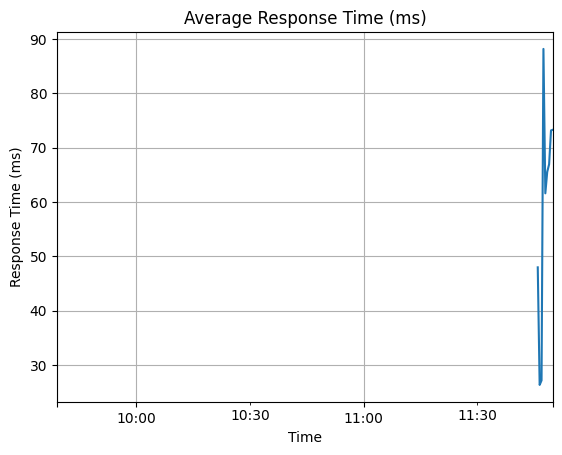

In [4]:
# Display the data
if df.empty:
    print("No trace data found.")
else:
    # print(df)

    # Calculate and plot average response time
    avg_response_time = df.groupby(pd.Grouper(key='start_time', freq='30s'))['duration'].mean() 
    avg_response_time.plot(y='duration', kind='line', title='Average Response Time (ms)')
    plt.xlabel('Time')
    plt.ylabel('Response Time (ms)')
    plt.grid(True)
    plt.show()
    
 

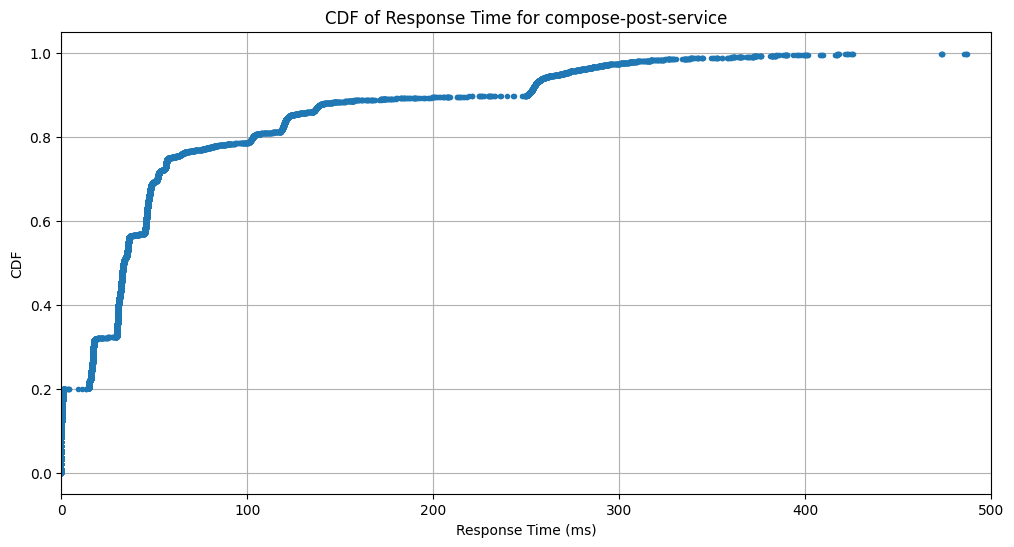

In [5]:

# Check if data is available
if df.empty:
    print("No trace data found.")
else:
    # Convert start_time to datetime for time-based grouping
    
    # Ensure 'duration' column is numeric
    df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
    
    # Drop rows with NaN values in 'duration'
    df = df.dropna(subset=['duration'])

    # Sort the duration values
    sorted_duration = df['duration'].sort_values()

    # Calculate CDF values
    cdf = sorted_duration.rank(method='average', pct=True)

    # Plot the CDF
    plt.figure(figsize=(12, 6))
    plt.plot(sorted_duration, cdf, marker='.', linestyle='none')
    plt.title('CDF of Response Time for compose-post-service')
    plt.xlim(0,500)
    plt.xlabel('Response Time (ms)')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.show()
